Import Necessary Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

Load The Data

In [2]:
import pandas as pd

training_data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
validation_data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

In [3]:
training_data.shape

(74681, 4)

In [4]:
validation_data.shape

(999, 4)

In [5]:
training_data.dtypes

2401                                                      int64
Borderlands                                              object
Positive                                                 object
im getting on borderlands and i will murder you all ,    object
dtype: object

In [6]:
training_data.describe()

,2401
count,74681.000000
mean,6432.640149
std,3740.423819
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [7]:
training_data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
validation_data.head()


,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


Data Preprocessing

In [9]:
training_data.columns = ['ID', 'Entity', 'Sentiment', 'Message']
validation_data.columns = ['ID', 'Entity', 'Sentiment', 'Message']

In [10]:
training_data['Message'] = training_data['Message'].astype(str).fillna('')
validation_data['Message'] = validation_data['Message'].astype(str).fillna('')

Explanatory Data Analysis

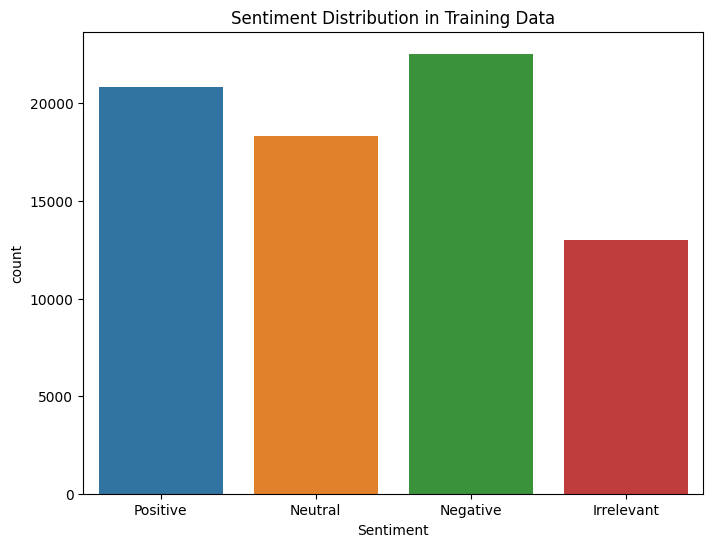

In [11]:
# EDA 1: Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=training_data)
plt.title('Sentiment Distribution in Training Data')
plt.show()

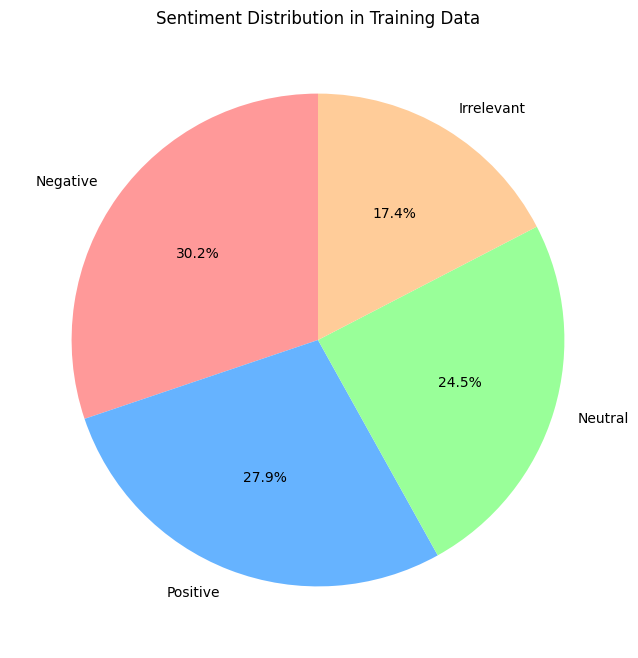

In [12]:
sentiment_counts = training_data['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Sentiment Distribution in Training Data')
plt.show()

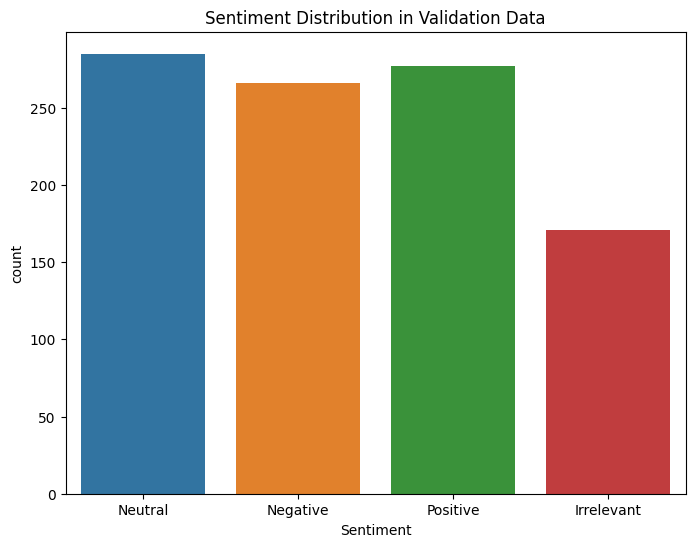

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=validation_data)
plt.title('Sentiment Distribution in Validation Data')
plt.show()

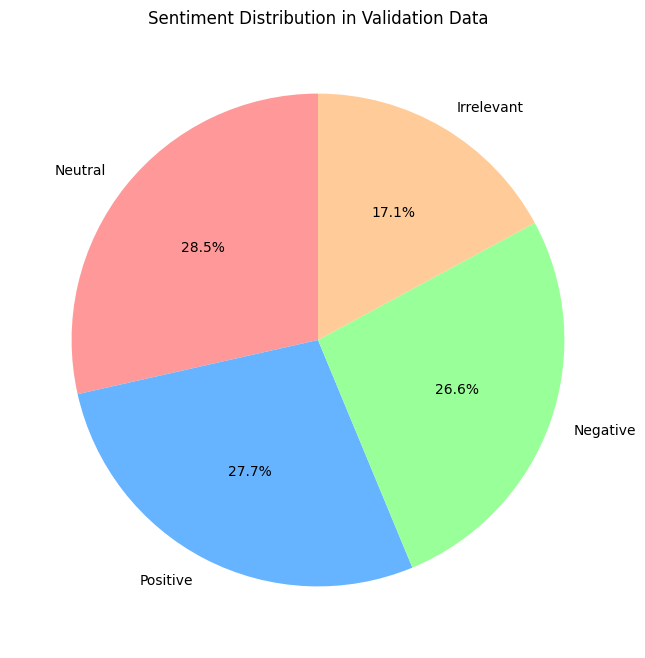

In [14]:
sentiment_counts = validation_data['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Sentiment Distribution in Validation Data')
plt.show()

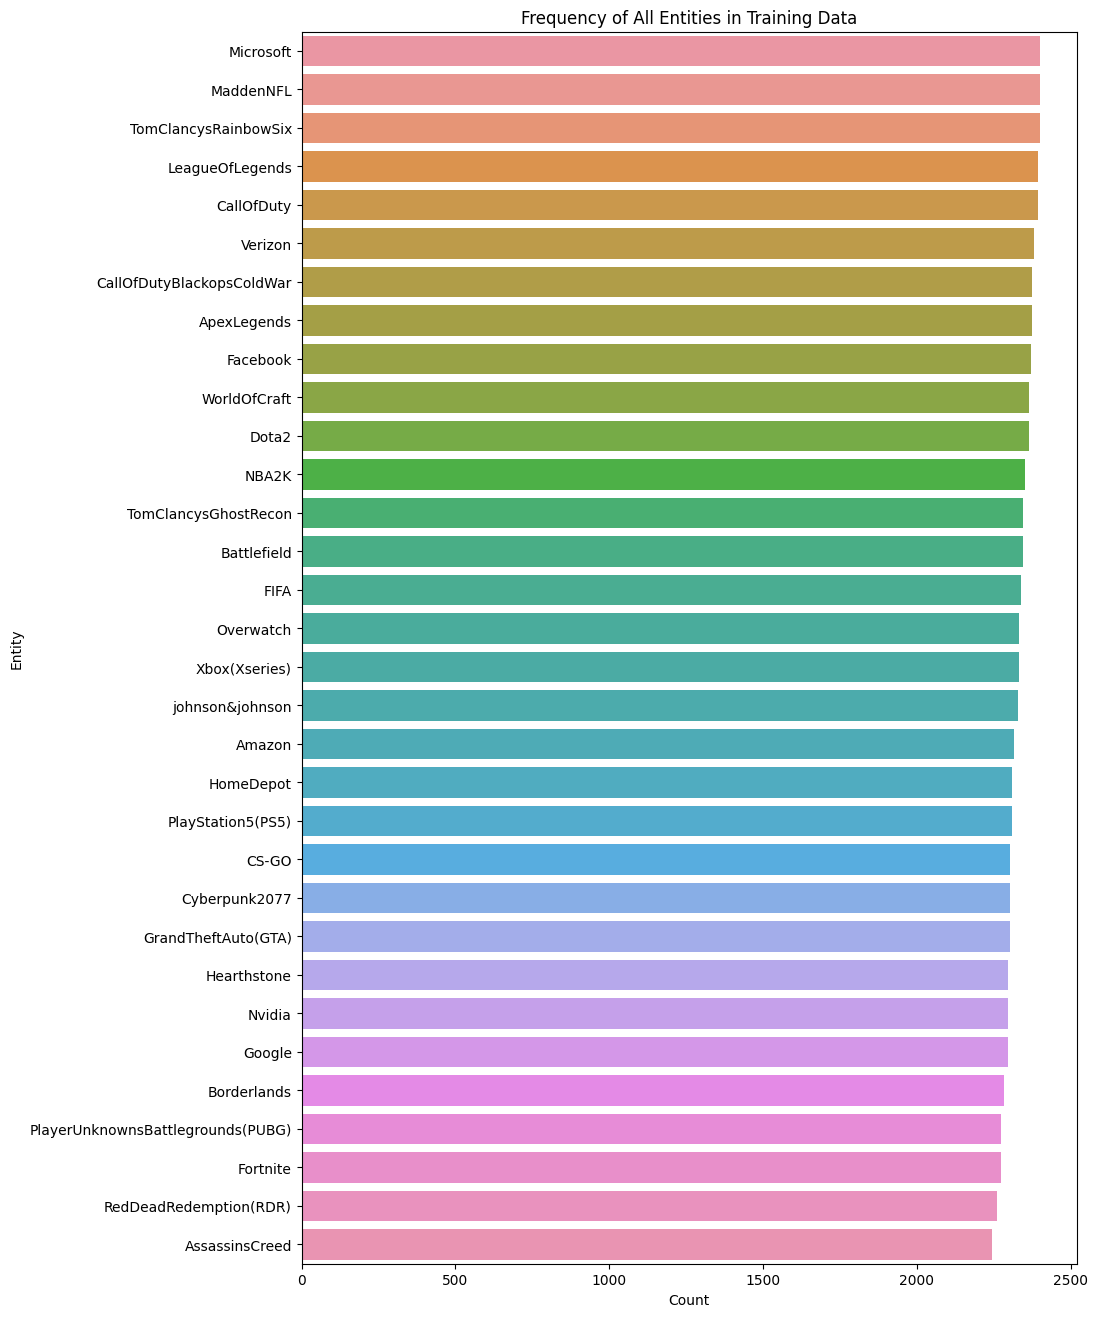

In [15]:
# EDA 2: Frequency of All Entities in Training Data
entity_counts = training_data['Entity'].value_counts()

plt.figure(figsize=(10, len(entity_counts) / 2))  
sns.barplot(y=entity_counts.index, x=entity_counts.values, orient='h')
plt.title('Frequency of All Entities in Training Data')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.show()

<Figure size 1200x800 with 0 Axes>

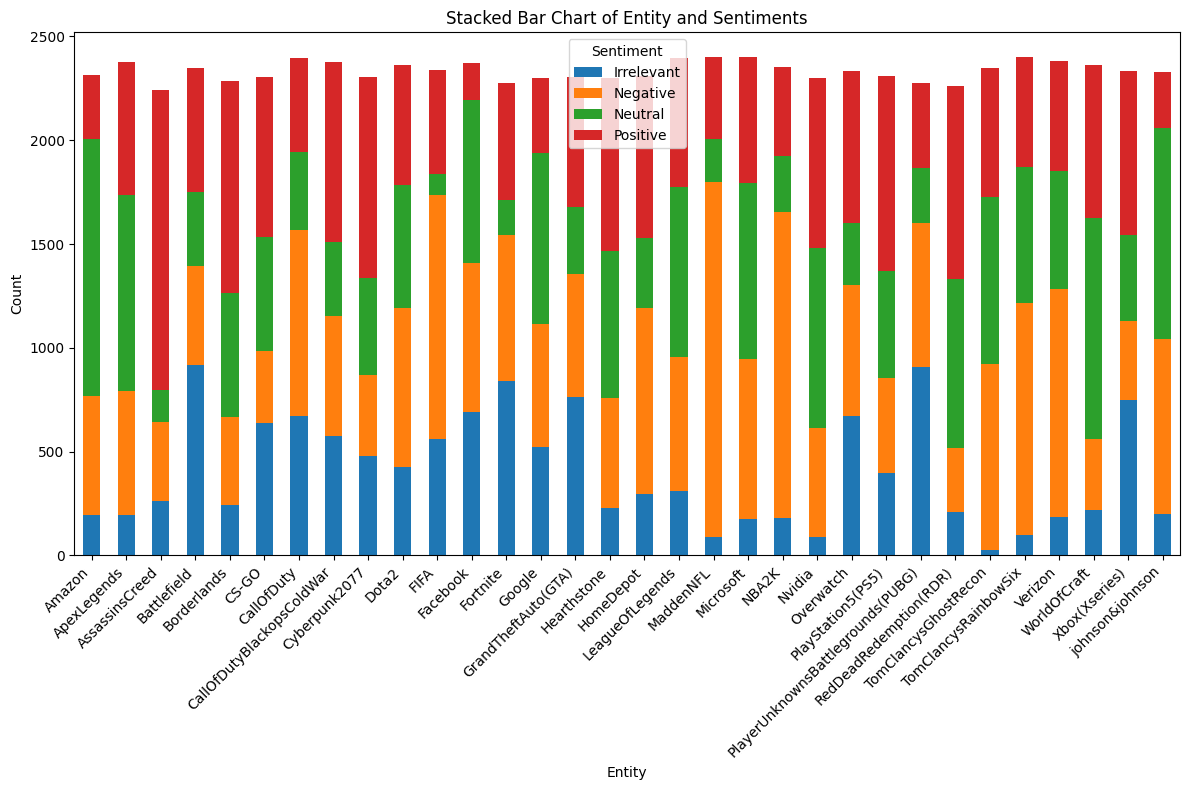

In [16]:
# EDA 3: Stacked Bar Chart of Sentiment Distribution by Entity
entity_sentiment_counts = pd.crosstab(training_data['Entity'], training_data['Sentiment'])

plt.figure(figsize=(12, 8))
entity_sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of Entity and Sentiments')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
# EDA 4: Message Length Distribution
training_data['Message_Length'] = training_data['Message'].apply(len)
validation_data['Message_Length'] = validation_data['Message'].apply(len)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


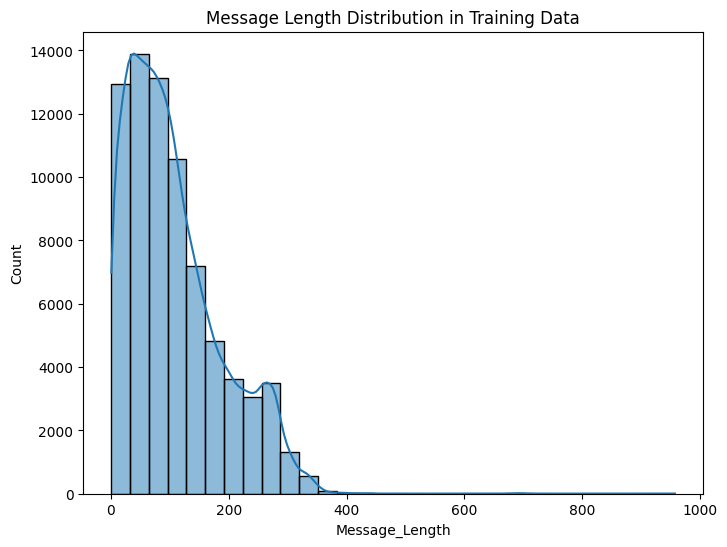

In [18]:
plt.figure(figsize=(8, 6))
sns.histplot(training_data['Message_Length'], kde=True, bins=30)
plt.title('Message Length Distribution in Training Data')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


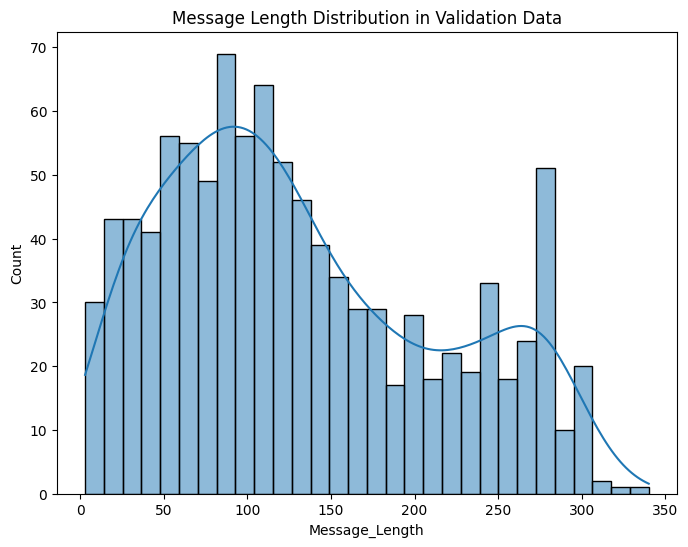

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(validation_data['Message_Length'], kde=True, bins=30)
plt.title('Message Length Distribution in Validation Data')
plt.show()

In [20]:
# EDA 5: Wordcloud
# Filter messages based on sentiment categories
positive_messages = ' '.join(training_data[training_data['Sentiment'] == 'Positive']['Message'])
negative_messages = ' '.join(training_data[training_data['Sentiment'] == 'Negative']['Message'])
neutral_messages = ' '.join(training_data[training_data['Sentiment'] == 'Neutral']['Message'])
irrelevant_messages = ' '.join(training_data[training_data['Sentiment'] == 'Irrelevant']['Message'])

In [21]:
# Create word clouds for each sentiment category
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_messages)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_messages)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_messages)
wordcloud_irrelevant = WordCloud(width=800, height=400, background_color='white').generate(irrelevant_messages)

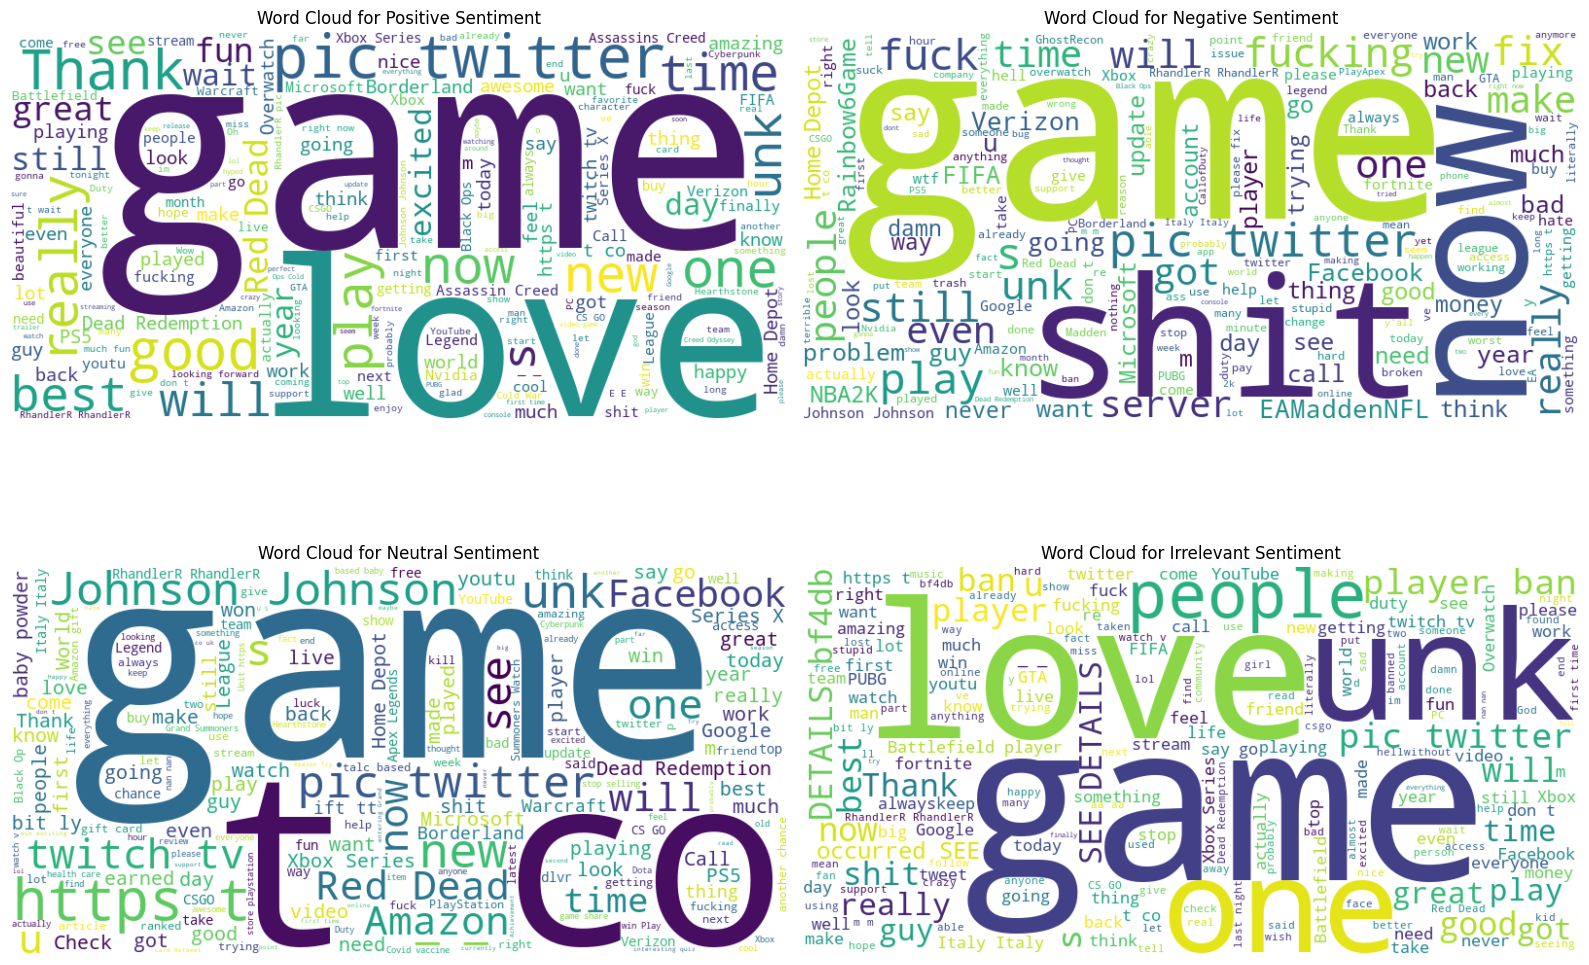

In [22]:
# Set up subplots to show all word clouds
plt.figure(figsize=(16, 12))

# Plot Positive WordCloud
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
# Plot Negative WordCloud
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

# Plot Neutral WordCloud
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud for Neutral Sentiment')
plt.axis('off')

# Plot Irrelevant WordCloud
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_irrelevant, interpolation='bilinear')
plt.title('Word Cloud for Irrelevant Sentiment')
plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()

TF-IDF Vectorization

In [23]:
# Preprocess the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [24]:
# Transform the training and validation messages
X_train_tfidf = tfidf_vectorizer.fit_transform(training_data['Message'])
X_validation_tfidf = tfidf_vectorizer.transform(validation_data['Message'])

In [25]:
# Target labels
y_train = training_data['Sentiment']
y_validation = validation_data['Sentiment']

K-Means++ Clustering

In [26]:
wcss = []
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_train_tfidf)
    wcss.append(kmeans.inertia_) 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


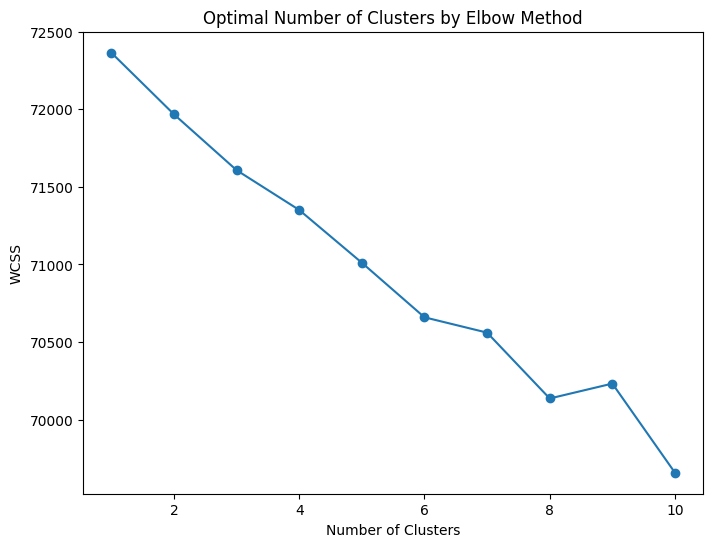

In [27]:
# Plot the WCSS 
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Optimal Number of Clusters by Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
# Initialize the KMeans model
kmeans_model = KMeans(n_clusters=6, init='k-means++', random_state=42)

In [29]:
# Train the model
kmeans_model.fit(X_train_tfidf)

KMeans(n_clusters=6, random_state=42)

In [30]:
# 3. Predict cluster labels for the validation set
cluster_labels = kmeans_model.predict(X_train_tfidf)

In [31]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

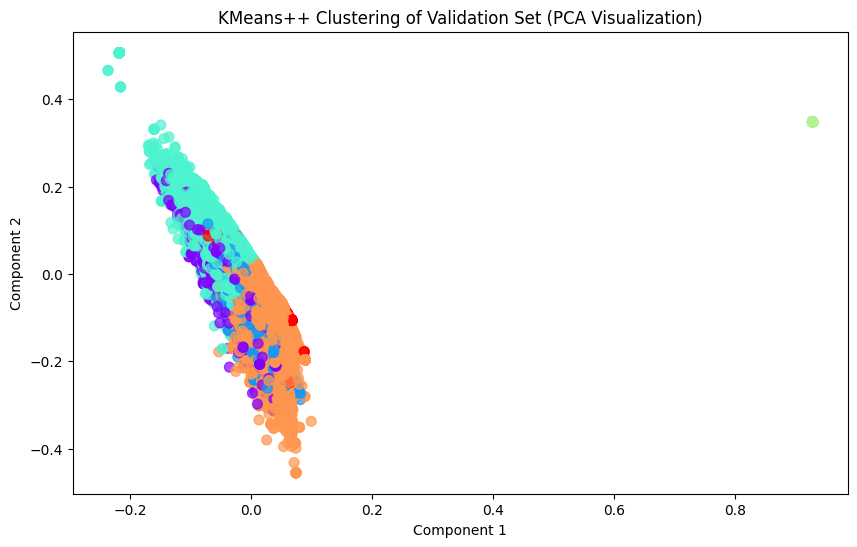

In [32]:
# Plot the PCA result with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7)
plt.title('KMeans++ Clustering of Validation Set (PCA Visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [33]:
import numpy as np
np.unique(cluster_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 6812,  6786, 23553,   686, 36494,   350]))

Naive Bayes Classifier

In [34]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_validation_tfidf)

In [35]:
accuracy_nb = accuracy_score(y_validation, y_pred_nb)
report_nb = classification_report(y_validation, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Naive Bayes Classification Report:\n", report_nb)

Naive Bayes Accuracy: 0.7137137137137137
Naive Bayes Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.83      0.51      0.63       171
    Negative       0.66      0.83      0.74       266
     Neutral       0.78      0.62      0.69       285
    Positive       0.68      0.82      0.75       277

    accuracy                           0.71       999
   macro avg       0.74      0.70      0.70       999
weighted avg       0.73      0.71      0.71       999



Logistic Regression

In [36]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_validation_tfidf)

In [37]:
accuracy_lr = accuracy_score(y_validation, y_pred_lr)
report_lr = classification_report(y_validation, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Classification Report:\n", report_lr)

Logistic Regression Accuracy: 0.8158158158158159
Logistic Regression Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.82      0.73      0.77       171
    Negative       0.79      0.88      0.83       266
     Neutral       0.86      0.77      0.81       285
    Positive       0.80      0.86      0.83       277

    accuracy                           0.82       999
   macro avg       0.82      0.81      0.81       999
weighted avg       0.82      0.82      0.81       999



Random Forest

In [38]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth= 100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_validation_tfidf)

In [39]:
accuracy_rf = accuracy_score(y_validation, y_pred_rf)
report_rf = classification_report(y_validation, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", report_rf)

Random Forest Accuracy: 0.933933933933934
Random Forest Classification Report:
               precision    recall  f1-score   support

  Irrelevant       1.00      0.85      0.92       171
    Negative       0.94      0.96      0.95       266
     Neutral       0.92      0.93      0.92       285
    Positive       0.91      0.96      0.93       277

    accuracy                           0.93       999
   macro avg       0.94      0.93      0.93       999
weighted avg       0.94      0.93      0.93       999



Decision Tree

In [40]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

In [41]:
# Train the model
dt_model.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(random_state=42)

In [42]:
# Make predictions on the validation set
y_pred_dt = dt_model.predict(X_validation_tfidf)

In [43]:
# Evaluate the model
accuracy_dt = accuracy_score(y_validation, y_pred_dt)
report_dt = classification_report(y_validation, y_pred_dt)

In [44]:
# Classification Report 
print("Decision Tree Model Accuracy:", accuracy_dt)
print("Decision Tree Model Classification Report:\n", report_dt)

Decision Tree Model Accuracy: 0.8808808808808809
Decision Tree Model Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.89      0.83      0.86       171
    Negative       0.90      0.94      0.92       266
     Neutral       0.88      0.85      0.87       285
    Positive       0.86      0.89      0.87       277

    accuracy                           0.88       999
   macro avg       0.88      0.88      0.88       999
weighted avg       0.88      0.88      0.88       999



ANN

In [45]:
# Encode Sentiments into numerical values
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_validation_encoded = encoder.transform(y_validation)

In [46]:
# One-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_validation_categorical = to_categorical(y_validation_encoded)

In [47]:
# Build the neural network model
model = Sequential()

model.add(Dense(512, input_dim=X_train_tfidf.shape[1], activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
# Train the model
history = model.fit(X_train_tfidf.toarray(), y_train_categorical, epochs=10, batch_size=64, validation_data=(X_validation_tfidf.toarray(), y_validation_categorical))

Epoch 1/10


I0000 00:00:1728736686.283291      74 service.cc:145] XLA service 0x79a598005c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728736686.283355      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  71/1167 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3284 - loss: 1.3614

I0000 00:00:1728736689.972348      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5653 - loss: 1.0172 - val_accuracy: 0.9289 - val_loss: 0.2688
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8630 - loss: 0.3790 - val_accuracy: 0.9630 - val_loss: 0.1371
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9225 - loss: 0.2079 - val_accuracy: 0.9630 - val_loss: 0.1302
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9364 - loss: 0.1623 - val_accuracy: 0.9710 - val_loss: 0.1188
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9449 - loss: 0.1356 - val_accuracy: 0.9720 - val_loss: 0.1315
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9495 - loss: 0.1198 - val_accuracy: 0.9700 - val_loss: 0.1498
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9513 - loss: 0.1132 - val_accuracy: 0.9720 - val_loss: 0.1374
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9537 - loss: 0.1089 - val_accura

In [49]:
# Make predictions on the validation set
y_pred_ann = model.predict(X_validation_tfidf.toarray())
y_pred_ann_labels = np.argmax(y_pred_ann, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [50]:
# Decode the predicted labels
y_pred_labels = encoder.inverse_transform(y_pred_ann_labels)

In [51]:
# Evaluate the model
accuracy_ann = accuracy_score(y_validation, y_pred_labels)
report_ann = classification_report(y_validation, y_pred_labels)

In [52]:
# Classification Report 
print("ANN Model Accuracy:", accuracy_ann)
print("ANN Model Classification Report:\n", report_ann)

ANN Model Accuracy: 0.975975975975976
ANN Model Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.98      0.96      0.97       171
    Negative       0.98      0.98      0.98       266
     Neutral       0.98      0.98      0.98       285
    Positive       0.97      0.98      0.97       277

    accuracy                           0.98       999
   macro avg       0.98      0.97      0.98       999
weighted avg       0.98      0.98      0.98       999



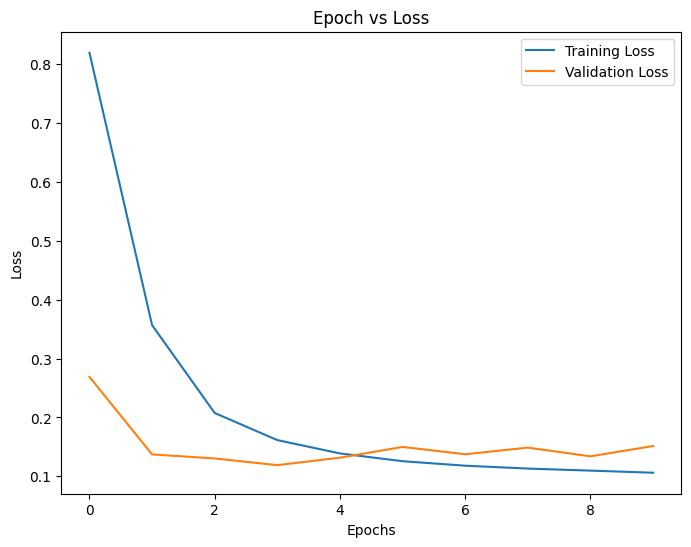

In [53]:
#Plot the loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Conclusion: The model that delivers the best performance overall is Artificial Neural Network (ANN) with 97% accuracy